# Tutorial 03
## Feature transformation & selection

#### Import

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data
We use [a dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from Kaggle.
It contains 80 features describing sold houses. 
The features describe house locations, its physical attributes and sales information.
See data_description.txt for more details.

We want to predict the sale prices (SalePrice column, called as "target" variable or "label") based on the remaining 79 explanatory features.

In [3]:
# if you download the data from Kaggle, run following code
# to remove Miscellaneous feature value 
# since we don't want to create several value variables for each feature (try it at home)

# df = pd.read_csv('data.csv')
# df.drop(['MiscVal'], axis=1, inplace = True, errors = 'ignore')
# df.to_csv('data.csv', index = False)

# df.MiscFeature.unique() # array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [4]:
df = pd.read_csv('data.csv')
display(df.head())
df.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,12,2008,WD,Normal,250000


(1460, 80)

Brief cleaning first. We would like to use some regression model to predict the sale prices (continuous values). Note that the main aim of this tutorial is not cleaning, but the feature transformation and selection. So we won't spend a lot of energy on cleaning.

In [5]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [6]:
# Fill all numer NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

Now we have several categorical features with some missings.

In [7]:
# list of categorical features with sum of missings
df.select_dtypes(include=['category']).isnull().sum()

# all features with missings
#df.columns[df.isnull().any()]

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [8]:
# just check the values
df['Alley'].unique()

[NaN, 'Grvl', 'Pave']
Categories (2, object): ['Grvl', 'Pave']

## Feature transformations

First, we focus on transformations that can help to increase the performance of prediction models.

Since we want to use the linear regression as a prediction model it is usually beneficial to convert categorical (especially nominal) variables into indicators which is called one hot encoding.

In [9]:
# Convert categorical variables to indicators and create new data
# pandas vytvoreni binarnich sloupcu pro categorialni priznaky
df = pd.get_dummies(df) # one-hot encoding
# preskakuje NaNy (vsude da 0)

# check that there are no missings now
print(df.isnull().any().any())

False


In [10]:
df.dtypes.value_counts()

uint8      252
int64       34
float64      3
dtype: int64

Lets also convert all non-indicator values to float64 - which would be useful later.

In [11]:
df[df.select_dtypes(['float64', 'int64']).columns] = df[df.select_dtypes(['float64', 'int64']).columns].astype('float64')

In [12]:
df.dtypes.value_counts()

uint8      252
float64     37
dtype: int64

#### Sometimes it is useful to introduce new features based on the original ones

In [13]:
print('Shape of the data:', df.shape)

Shape of the data: (1460, 289)


In [14]:
# Let us create new features as square roots of area features
# i.e. so they correspond to diameters of circles having the same area
# We also add indicators of zero values (usually missings) there

for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])

print('Shape of the data:', df.shape)

Shape of the data: (1460, 319)


In [15]:
# See the results for Area features
df[df.filter(regex='Area', axis=1).columns].head()

# LotArea: Lot size in square feet
# MasVnrArea: Masonry veneer area in square feet
# GrLivArea: Above grade (ground) living area square feet
# GarageArea: Size of garage in square feet
# PoolArea: Pool area in square feet

,LotArea,MasVnrArea,GrLivArea,GarageArea,PoolArea,HasLotArea,SqrtLotArea,HasMasVnrArea,SqrtMasVnrArea,HasGrLivArea,SqrtGrLivArea,HasGarageArea,SqrtGarageArea,HasPoolArea,SqrtPoolArea
0,8450.0,196.0,1710.0,548.0,0.0,1,91.923882,1,14.000000,1,41.352146,1,23.409400,0,0.0
1,9600.0,0.0,1262.0,460.0,0.0,1,97.979590,0,0.000000,1,35.524639,1,21.447611,0,0.0
2,11250.0,162.0,1786.0,608.0,0.0,1,106.066017,1,12.727922,1,42.261093,1,24.657656,0,0.0
3,9550.0,0.0,1717.0,642.0,0.0,1,97.724101,0,0.000000,1,41.436699,1,25.337719,0,0.0
4,14260.0,350.0,2198.0,836.0,0.0,1,119.415242,1,18.708287,1,46.882833,1,28.913665,0,0.0


C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SqrtLotArea'>

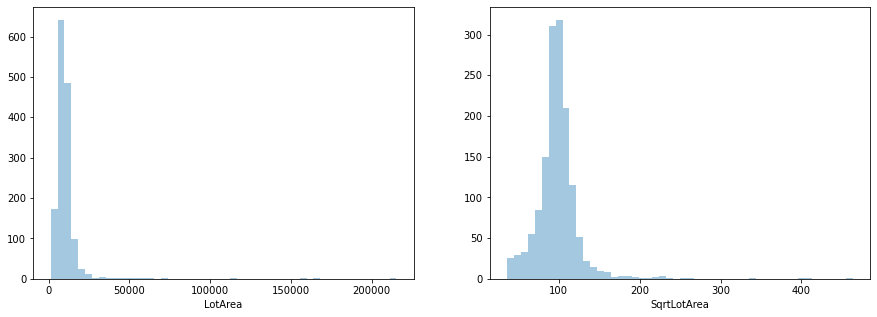

In [16]:
# Distribution visualisation
f, axes = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(df[df.LotArea>0].LotArea, ax=axes[0], kde=False) 
sns.distplot(df[df.LotArea>0].SqrtLotArea, ax=axes[1], kde=False)

#### Constant features removal
They are not beneficial for the model.

In [17]:
# Remove constant features
display(df.columns[df.min() == df.max()])
df = df[df.columns[df.min() != df.max()]]

Index(['HasLotArea', 'Has1stFlrSF', 'HasGrLivArea'], dtype='object')

#### Split train &validation data to be able to study the influence of further steps

In [18]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


#### Prepare models run to be able to study the influence of further steps

In [19]:
def linreg(train, validate, plot = True, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSE
    print(f'Linear regression root mean squared validation error: {np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)):.0f}')
    if train_error:
        print(f'Linear regression root mean squared train error: {np.sqrt(metrics.mean_squared_error(clf.predict(X), y)):.0f}')
    
    # Plot
    if plot:
        plt.scatter(yv, clf.predict(Xv))
        plt.plot([0,600000], [0,600000], 'r')
        plt.show()

def ridgereg(train, validate, plot = True, train_error = True, print_opt = False): 
    # Prepare functions to automatic alpha determination using cross validation
    def scorer(Y, yp):
        return np.sqrt(metrics.mean_squared_error(Y, yp)) # RMSE as scorer
    def ridgemodel(alpha):
        clf = linear_model.Ridge(alpha=alpha)
        return np.mean(model_selection.cross_val_score(clf, X, y, cv=5, scoring=metrics.make_scorer(scorer)))

    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
    
    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    if print_opt:
        print(opt_alpha)
    
    # Ridge regression model
    clf = linear_model.Ridge(alpha=opt_alpha.x)
    clf.fit(X, y) 
    
    # Print RMSE
    print(f'Ridge regression root mean squared validation error: {np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)):.0f}')
    if train_error:
        print(f'Ridge regression root mean squared train error: {np.sqrt(metrics.mean_squared_error(clf.predict(X), y)):.0f}')
    # Plot
    if plot:
        plt.scatter(yv, clf.predict(Xv))
        plt.plot([0,600000], [0,600000], 'r')
        plt.show()

Linear regression root mean squared validation error: 27635
Linear regression root mean squared train error: 18135


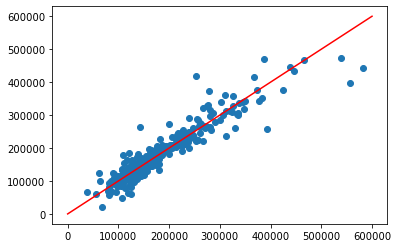

----------------------------------------------------

Ridge regression root mean squared validation error: 26872
Ridge regression root mean squared train error: 23450


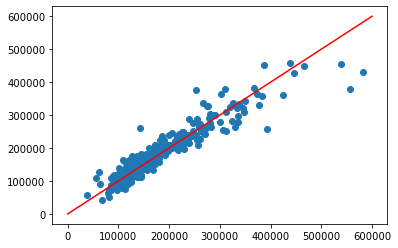

In [20]:
# Run both models
linreg(dt, dv)
print("----------------------------------------------------\n")
ridgereg(dt, dv)

We can see that without any special transformations and feature selection ridge regression is better than pure linear regression.

## Features normalization
Rescale features in a way that they are be more comparable. Normalization of some features can improve the performance (e.g. ridge regression).

We will focus on:
* **Standardization** - result has a sample mean 0 and sample variance 1,
* **Min-max normalization** - the resulting range is [0,1].
    * Citliva na outliers - je treba znat data pred pouzitim

### Task - discuss which features are reasonable to normalization

In [23]:
# Your code here (if you need any)
print(dt.dtypes.value_counts())

uint8      264
float64     51
float16      1
dtype: int64


In [22]:
# Standardization
standard_scaler = preprocessing.StandardScaler()
# Min-max normalization
minmax_scaler = preprocessing.MinMaxScaler()

# we rescale only numeric values - not indicators (not dummy-created columns)
columns = dt.select_dtypes(include=['float64']).columns 
columns = columns.drop('SalePrice', errors = 'ignore')
print('Columns to be normalized: ', list(columns))

# Prepare values for the transformation
standard_scaler.fit(dt[columns])
minmax_scaler.fit(dt[columns])

# Transform of both train and validation
# Standardization
dt_s = dt.copy()
dv_s = dv.copy()
dt_s[columns] = standard_scaler.transform(dt[columns])
dv_s[columns] = standard_scaler.transform(dv[columns])
# MinMax
dt_m = dt.copy()
dv_m = dv.copy()
dt_m[columns] = minmax_scaler.transform(dt[columns])
dv_m[columns] = minmax_scaler.transform(dv[columns])

Columns to be normalized:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SqrtLotArea', 'SqrtMasVnrArea', 'SqrtBsmtFinSF1', 'SqrtBsmtFinSF2', 'SqrtBsmtUnfSF', 'SqrtTotalBsmtSF', 'Sqrt1stFlrSF', 'Sqrt2ndFlrSF', 'SqrtLowQualFinSF', 'SqrtGrLivArea', 'SqrtGarageArea', 'SqrtWoodDeckSF', 'SqrtOpenPorchSF', 'SqrtPoolArea']


C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='OverallQual'>

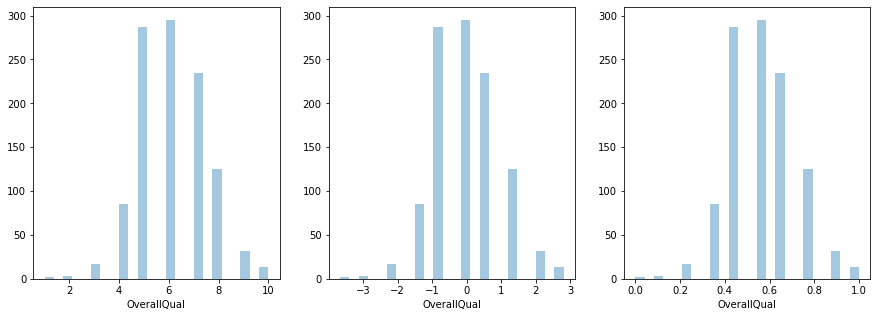

In [23]:
# Distribution of one concrete feature (an ordinal one)
f, axes = plt.subplots(1, 3, figsize=(15,5))
sns.distplot(dt.OverallQual, kde = False, ax = axes[0])
sns.distplot(dt_s.OverallQual, kde = False, ax = axes[1])
sns.distplot(dt_m.OverallQual, kde = False, ax = axes[2])

Standardized data
Linear regression root mean squared validation error: 18090652083283
Linear regression root mean squared train error: 18135


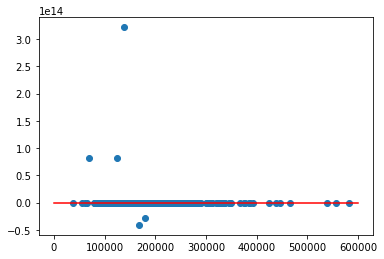

----------------------------------------------------

Ridge regression root mean squared validation error: 26608
Ridge regression root mean squared train error: 25018


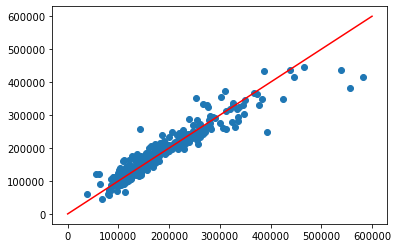



MinMax normalized data
Linear regression root mean squared validation error: 932418596381930
Linear regression root mean squared train error: 18844


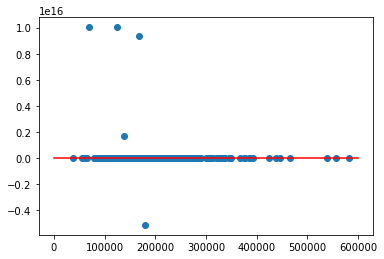

----------------------------------------------------

Ridge regression root mean squared validation error: 27198
Ridge regression root mean squared train error: 25481


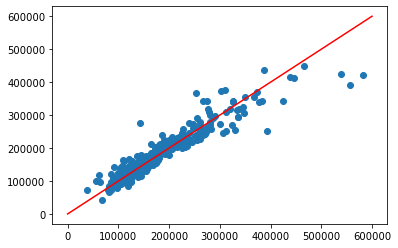

In [24]:
# Run both models
print('Standardized data')
linreg(dt_s, dv_s)
print("----------------------------------------------------\n")
ridgereg(dt_s, dv_s)

print('\n============================================\n\nMinMax normalized data')
linreg(dt_m, dv_m)
print("----------------------------------------------------\n")
ridgereg(dt_m, dv_m)

Standardization was beneficial for Ridge regression but completely destroyed the results for linear regression.

## Feature selection
Feature selection can help to decrease the complexity of the model which:
* prevents overfitting
* helps to speedup training

### Find irrelevant features - filter methods
First focus on the so called **filter methods** where we assess individual features, independently of other features, according to some quality measure (e.g. the variance, the correlation with the target variable,...). Filter methods are supposed to suppress the least interesting variables.

Some features are irrelevant just because of our **domain knowledge**.

In [25]:
# Drop Id - we will store all features to drop in the columns_to_remove list
columns_to_remove = ['Id']

#### Variance approach
Others can be detected as a variables with very **low variance**. It means that they are almost constant. 

Be careful, this is strongly influenced by previous transformations!

E.g. when standardization was applied - all variables have variance 1.

In [26]:
# Find features with low variance - we assume that they cannot help to infer the observable
# this makes sense especially for indicators
# note that after the standardization all non-indicator variables have variance 1
# note that for an indicator with true prob p is the var given by p*(1-p) - for p = 0.01 we have 0.0099

columns_to_remove = list(set(list(dt_s.columns[dt_s.var() < 0.01]) + columns_to_remove)) 

# top largest < 0.01
print(dt_s[columns_to_remove].var().nlargest(5))
# # top smallest
print(dt_s[columns_to_remove].var().nsmallest(5))
# # number of small ones
print(len(columns_to_remove))

Id                      1.000914
SaleCondition_Alloca    0.009954
HouseStyle_2.5Unf       0.009954
MasVnrType_BrkCmn       0.009954
LandSlope_Sev           0.009057
dtype: float64
RoofMatl_Metal        0.000000
Utilities_NoSeWa      0.000000
Utilities_AllPub      0.000000
Condition2_RRNn       0.000000
Exterior2nd_CBlock    0.000913
dtype: float64
91


A more sophisticated approach is to study the relation of a feature to the target variable.

#### Correlation approach

Analysis of the correlation with the target variable. Note that Linear scaling of features doesn't influence the result.

In [27]:
# Correlation matrix Pearson & Spearman
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [28]:
# Pearson top 10 with target
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
display(corrP.SalePrice.loc[corrP_cols])
# Spearman top 10 with target
corrS_cols = corrS.SalePrice.abs().nlargest(10).index
display(corrS.SalePrice.loc[corrS_cols])

SalePrice        1.000000
OverallQual      0.791963
SqrtGrLivArea    0.707052
GrLivArea        0.703866
GarageCars       0.645009
GarageArea       0.622276
Sqrt1stFlrSF     0.615341
1stFlrSF         0.615080
TotalBsmtSF      0.614957
ExterQual_TA    -0.574401
Name: SalePrice, dtype: float64

SalePrice         1.000000
OverallQual       0.810410
GrLivArea         0.735184
SqrtGrLivArea     0.735184
GarageCars        0.694128
GarageArea        0.648908
SqrtGarageArea    0.648908
YearBuilt         0.644751
FullBath          0.642719
GarageYrBlt       0.632785
Name: SalePrice, dtype: float64

<AxesSubplot:>

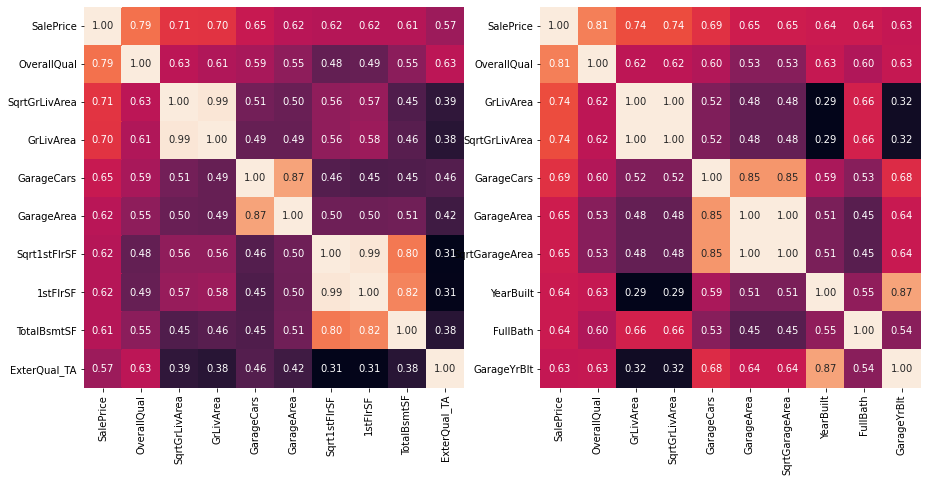

In [29]:
# Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

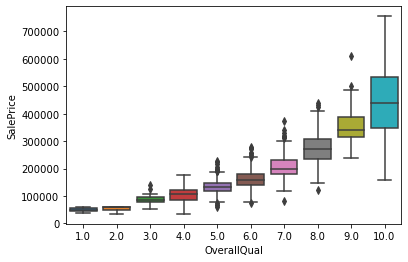

In [30]:
# OverallQual is an ordinal categorical variable stored in numbers
sns.boxplot(x='OverallQual', y='SalePrice', data=dt)

This can be used to remove features that are almost not correlated with the target variable. 

It makes sense for linear regression.

For non-linear models one has to be more careful since the correlation measures only the **linear** relation. They might be full functionally dependent (but not linearly) and have correlation 0.

In [31]:
# One can remove those with correlation smaller than some treshold.
additional_columns = list(corrP.SalePrice[corrP.SalePrice.abs() < 0.001].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['BsmtFinSF2', 'BsmtHalfBath', 'Condition1_RRAn', 'Fence_GdPrv']


In [32]:
# Alternatively, if we don't want to set a treshold in correlation values (we don't know what value to choose)
# we can do the analogous selection based on p-values of statistical test about the zero correlation

# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

# calculate p-values of the corresponding F-test
Fscores, pvals = feature_selection.f_regression(X,y)
pvals_result = pd.Series(pvals, index = X.columns)
print("5 largest P-values:")
display(pvals_result.nlargest(5))
print("5 smallest (absolute value) correlations:")
display(corrP.SalePrice.drop(columns_to_remove, errors = 'ignore').abs().nsmallest(5))

5 largest P-values:


LandContour_Lvl         0.925093
LotConfig_FR2           0.819261
BldgType_TwnhsE         0.762734
Neighborhood_SawyerW    0.736229
Heating_GasW            0.659390
dtype: float64

5 smallest (absolute value) correlations:


LandContour_Lvl         0.002845
LotConfig_FR2           0.006913
BldgType_TwnhsE         0.009133
Neighborhood_SawyerW    0.010191
Heating_GasW            0.013334
Name: SalePrice, dtype: float64

In [33]:
# One can remove those with p-value smaller than some treshold. 80%
additional_columns = list(pvals_result[pvals_result > 0.8].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove = list(set(columns_to_remove + additional_columns))

['LandContour_Lvl', 'LotConfig_FR2']


#### T-test approach for indicator variables
For indicator variables we can measure if the value of the indicator influences the value of the target variable. If not, then it is probably not a relevant feature (especially for linear regression).

We shall use the t-test to check whether the value of a selected indicator influence on the mean of the target variable.

In [34]:
# Perform t-test with indicator variables - calculate p-values
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: stats.ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

# show largest and smallest p-values
display(ttest_pvals.nlargest(5))
display(ttest_pvals.nsmallest(5))

LotConfig_Corner        0.880203
BldgType_TwnhsE         0.853574
Heating_GasW            0.447864
Neighborhood_SawyerW    0.439773
Exterior2nd_BrkFace     0.435870
dtype: float64

KitchenQual_TA       8.315298e-95
ExterQual_TA         5.601284e-93
BsmtQual_TA          4.684438e-82
Foundation_PConc     2.762385e-79
GarageType_Detchd    1.417977e-73
dtype: float64

What does this mean?

<AxesSubplot:xlabel='LotConfig_Corner', ylabel='SalePrice'>

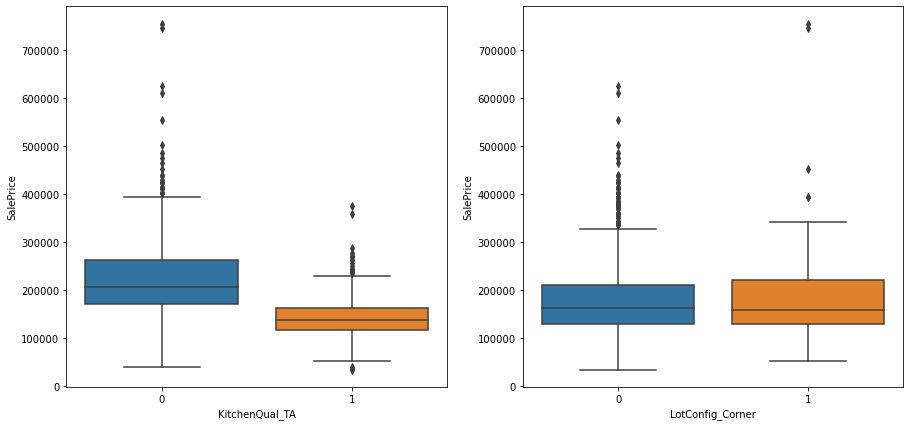

In [35]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(x='KitchenQual_TA', y='SalePrice', data=dt,ax=axs[0])
sns.boxplot(x='LotConfig_Corner', y='SalePrice', data=dt,ax=axs[1])

We can see that small $p$-values corresponds to high differentiation in a target variable.

In [36]:
# Remove all larger than 60%
columns_to_remove = list(set(columns_to_remove + list(ttest_pvals[ttest_pvals > 0.6].index)))
print(len(columns_to_remove))

99


In [37]:
dt2 = dt.copy()
dv2 = dv.copy()

In [38]:
# Final removal from all datasets
dt.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_s.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dv_m.drop(columns_to_remove, axis = 1, errors = 'ignore', inplace=True)
dt.shape

(1095, 217)

Linear regression root mean squared validation error: 29029
Linear regression root mean squared train error: 23339


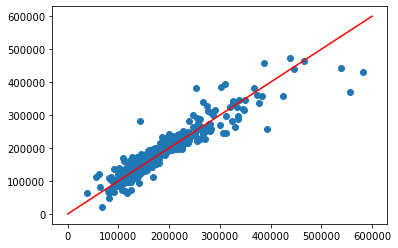

----------------------------------------------------

Ridge regression root mean squared validation error: 27403
Ridge regression root mean squared train error: 24590


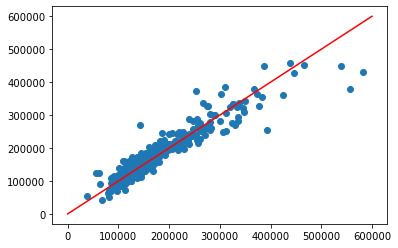

In [39]:
# Run both models
linreg(dt, dv)
print("----------------------------------------------------\n")
ridgereg(dt, dv)

Zjistili sme, ze se po nasich upravach MSE zhorsio trochu ... je treba prubezne kontrolovat ty zmeny, abysme naopak nezmenili/neodebrali neco, co je pro predikci modelu dulezity

## **Poznamka: statisticke metody sice zajimave, ale corelace je asi overall lepsi**

### Subset selection based on models - wrapper methods
Wrapper methods evaluate subsets of variables. Hence they can properly work with possible interactions between variables.
Moreover they are usually linked to the underlying learning algorithm.

The two main disadvantages of these methods are:
* The increasing overfitting risk when the number of observations is insufficient.
* The significant computation time when the number of variables is large.

Because of the computional complexity usual aproaches are greedy ones.

A simple approach is a backward Recursive Feature Elimination (http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE ).

In [40]:
# Recursive feature elimination (RFE) 

# Prepare the data
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

used_columns = X.columns

# define the scorer which will be the RMSE
def scorer(Y, yp):
    return np.sqrt(metrics.mean_squared_error(Y, yp))

# prepare the model
clfM = linear_model.LinearRegression()

# prepare the backward selection algorithm (recursive feature elimination with cross validation)
# step = 1 or greater, then corresponds to number of features to remove at each iteration
# cv = None, to use the default 5-fold cross-validation
selector = feature_selection.RFECV(clfM, step=1, cv=5, scoring=metrics.make_scorer(scorer))
# run it
selector = selector.fit(X, y)

# ranking_ The feature ranking, such that ranking_[i] corresponds to the 
# ranking position of the i-th feature. Selected features are assigned rank 1.

# transform result to dataframe
result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', len(columns_to_leave),'from ', result.Chosen.shape[0], 'features.')

,Chosen,Ranking
MSSubClass,False,5
LotFrontage,False,3
LotArea,False,6
GarageYrBlt,False,2
EnclosedPorch,False,4


Chosen 211 from  216 features.


In [41]:
print(X.shape)
print(y.shape)

(1095, 216)
(1095,)


Linear regression root mean squared validation error: 29064
Linear regression root mean squared train error: 23356


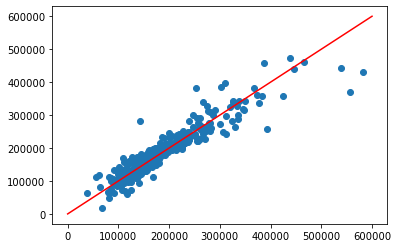

----------------------------------------------------

Ridge regression root mean squared validation error: 27476
Ridge regression root mean squared train error: 24615


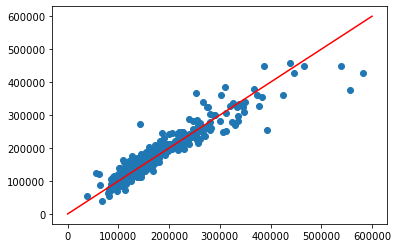

In [42]:
# Run both models
linreg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])
print("----------------------------------------------------\n")
ridgereg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])

Other possibility is to use the L^1 regularization (LASSO) which produces sparse weights in the linear model.
Then we can select all features with non-zero coefficients.

In [43]:
# The LASSO - L^1 regularized regression to obtain a sparse solution
# LASSO = least absolute shrinkage and selection operator
# Then the non-zero features may be extracted from the result.

# Prepare the data
X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

used_columns = X.columns

# We use the base estimator Lasso since the L1 norm promotes sparsity of features.
# alpha = Constant that multiplies the L1 term. Defaults to 1.0
# tol = The tolerance for the optimization, default = 1e-4
clfL = linear_model.Lasso(alpha = 10, max_iter = 10000, tol = 1e-2)

# SelectFromModel = meta-transformer for selecting features based on importance weights
sfm = feature_selection.SelectFromModel(clfL)
sfm.fit(X, y)

# transform result to dataframe
result = pd.DataFrame({'Chosen': sfm.get_support()}, index=list(used_columns))
# columns to leave
columns_to_leave = result[result.Chosen == True].index
# show results
display(result[result.Chosen == False].head(5))
print('Chosen', result.Chosen.sum(),'from ', result.Chosen.shape[0], 'features.')

,Chosen
LotShape_Reg,False
LandSlope_Gtl,False
Neighborhood_BrkSide,False
Neighborhood_SawyerW,False
Condition1_Artery,False


Chosen 187 from  216 features.


Linear regression root mean squared validation error: 28776
Linear regression root mean squared train error: 23400


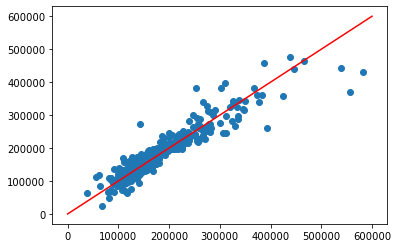

----------------------------------------------------

Ridge regression root mean squared validation error: 27476
Ridge regression root mean squared train error: 24429


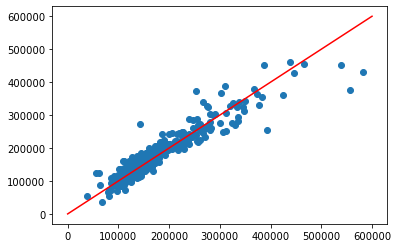

In [44]:
# Run both models
linreg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])
print("----------------------------------------------------\n")
ridgereg(dt[list(columns_to_leave) + ['SalePrice']], dv[list(columns_to_leave) + ['SalePrice']])

### Transformation of the target variable
It might be beneficial to transform the target variable as well.

C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


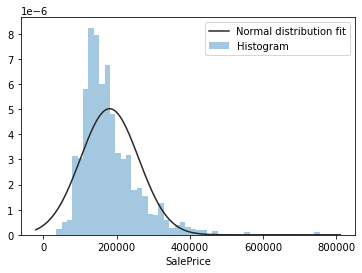

In [45]:
# Distribution of the target varaible
sns.distplot(df.SalePrice, 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             fit_kws = {'label': 'Normal distribution fit'},
             kde = False
            )

plt.legend()

We can see that the distribution is not normal.

Let's support this visual observation with a statistical test.

In [46]:
stats.normaltest(df.SalePrice)

NormaltestResult(statistic=610.8359109472653, pvalue=2.283848353787728e-133)

Since $p$-value is quite small, we can reject the null hypothesis that it has a normal distribution.

We can also estimate **skewness** as a measure of distributions asymetry and **kurtosis** as a measure of its "tailedness" (how the peak is sharped compared to how tails are long) in comparison to the normal distribution.

In [47]:
# Skewness and kurtosis as measures of asymetry and long tails
# Normal distribution has the Skewness = 0 and Kurtosis = 0 (Fisher's definition)
print('Skewness:', df.SalePrice.skew())
print('Kurtosis:', df.SalePrice.kurtosis())
# Again we see that the distribution is far from the normal distribution

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


We have some basic idea about the distribution of the target variable. Especially we see that it is not normal.

Let us now assume that we would like to use linear regression (possibly ridge) as a model to predict sale prices.
It is known (or can be easily found), the **least squares** method which is behind this model is actually equivalent to the maximum likelihood method when the target variable has a normal distribution.

Hence it is usually beneficial to transform the target variable in such a way that its new distribution will move 
towards the normal one.

In our case we can heuristically choose the logarithm.

Skewness: 0.12133506220520406
Kurtosis: 0.8095319958036296
NormaltestResult(statistic=25.507009834238303, pvalue=2.89216582205235e-06)


C:\Users\OndraS\anaconda3\envs\s\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


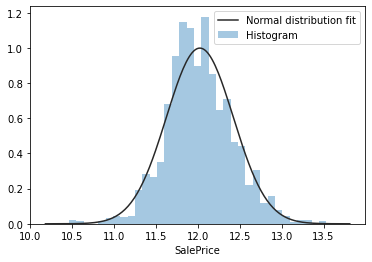

In [48]:
# observe the transformed distribution
sns.distplot(np.log(df.SalePrice), 
             fit=stats.norm,  # It should be fitted by the normal distribution
             hist_kws = {'label': 'Histogram'},
             fit_kws = {'label': 'Normal distribution fit'},
             kde = False
            )
plt.legend()

print('Skewness:', np.log(df.SalePrice).skew())
print('Kurtosis:', np.log(df.SalePrice).kurtosis())
 
print(stats.normaltest(np.log(df.SalePrice)))

It is not perfect but better that the original one.
So it should be worth trying it.